In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft, fftfreq, fftshift, ifft
from spectrum import *
from scipy import signal

In [3]:
from nt_toolbox.general import *
from nt_toolbox.signal import *
from nt_toolbox.compute_wavelet_filter import *

In [4]:
def show_image(title, img):
    plt.figure(figsize=(1.121, 1.5), dpi=1000)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.axis('off')
    plt.savefig(title + ".png", dpi=1000, bbox_inches="tight")
    plt.show()

In [5]:
def show_plot(title, x, y):
    plt.figure(title, figsize=(4, 3), dpi=100)
    plt.title(title)
    plt.plot(x, y)
    plt.savefig(title + ".png", dpi=100, bbox_inches="tight")
    plt.show()

In [6]:
def get_snr_db(img, noise):
    img_power = np.var(img)
    noise_power = np.var(noise)
    return 10*np.log10(img_power / noise_power)

In [7]:
def get_sigma_from_snr_db(snr_db, img):
    x = np.log10(np.var(img))
    y = snr_db / 10
    return 10 ** ((x-y)/2)

In [8]:
def find_element(l, el):
    ''' find an integer in a list of floats'''
    if not l:
        return None
    
    copy_l = [l[i] - el for i in range(len(l))]
    signal = copy_l[0] > 0
    
    for index in range(len(copy_l)):
        if ((copy_l[index] > 0) == signal):
            continue
        else:
            return index
            
    return None

In [9]:
def gaussian_noise(img, mean, var):
    return np.random.normal(mean, var, img.shape)

In [10]:
def calculate_gaussian_kernel(size=3, sigma=1):
    kernel = np.zeros((size, size))
    for g_i, k_i in zip(range(int(-size/2), int(size/2) + 1), range(0, size)):
        for g_j, k_j in zip(range(int(-size/2), int(size/2)+1), range(0, size)):
            kernel[k_i][k_j] = np.exp(-(g_i*g_i + g_j*g_j)/(2*sigma*sigma))/(2*np.pi*sigma*sigma)
    
    return kernel

In [11]:
def create_gaussian_kernel(size=3, sigma=1):
    h = signal.gaussian(size, sigma).reshape(size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

In [12]:
def wiener_denoise(img, gaussian_kernel, sigma):
    gaussian_kernel /= np.sum(gaussian_kernel)
    copy = np.copy(img)
    copy = np.fft.fft2(copy)
    gaussian_kernel = np.fft.fft2(gaussian_kernel, s = img.shape)
    gaussian_kernel = np.conj(gaussian_kernel / np.abs(gaussian_kernel) ** 2 + sigma)
    copy = copy * gaussian_kernel
    copy = np.abs(np.fft.ifft2(copy))
    return copy

In [13]:
barb = cv2.imread("barbara.jpg", 0)

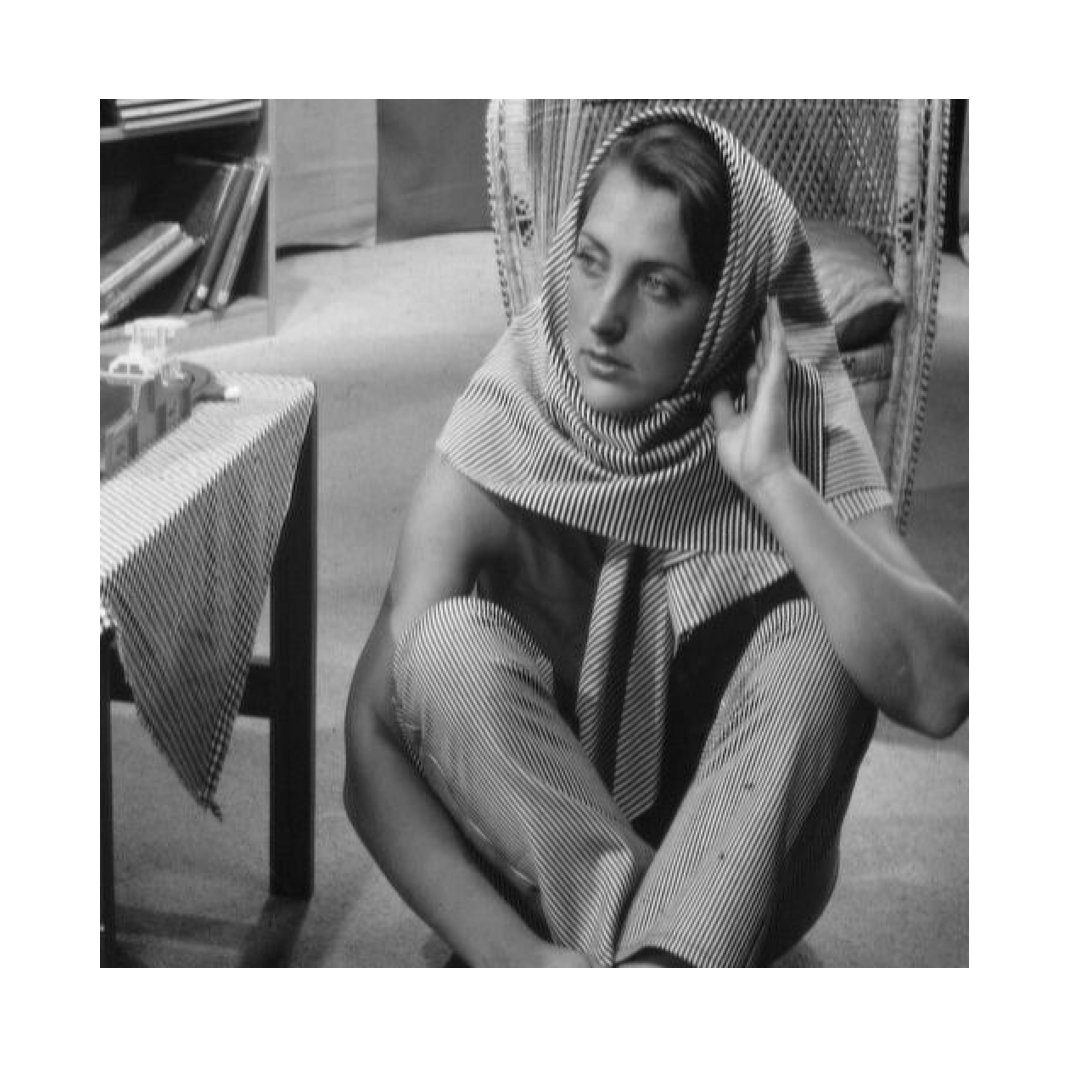

In [14]:
show_image("hey-barb", barb)

In [15]:
#x_axis = [sigma for sigma in np.arange(0.001, 60.001, 0.01)]

In [16]:
#snr_db_data = [get_snr_db(barb, gaussian_noise(barb, 0, sigma)) for sigma in x_axis]

In [17]:
#show_plot("SNR(db) for different sigma values of a white gaussian noise", x_axis, snr_db_data)

In [18]:
# barb sigma, 0 db
print(np.sqrt(np.var(barb)))

47.828561537051804


In [19]:
db_vals = [0.0, 10.0, 20.0]

In [20]:
sigma_vals = [get_sigma_from_snr_db(db, barb) for db in db_vals]

In [21]:
print(sigma_vals)

[47.82856153705181, 15.124719166660755, 4.782856153705182]


In [22]:
#x_vals = [find_element(snr_db_data, db) for db in db_vals]

In [23]:
#sigma_vals = [x_axis[i] for i in x_vals]

In [24]:
#print(sigma_vals)

In [25]:
def thresh_hard(u,t):return u*(abs(u)>t)

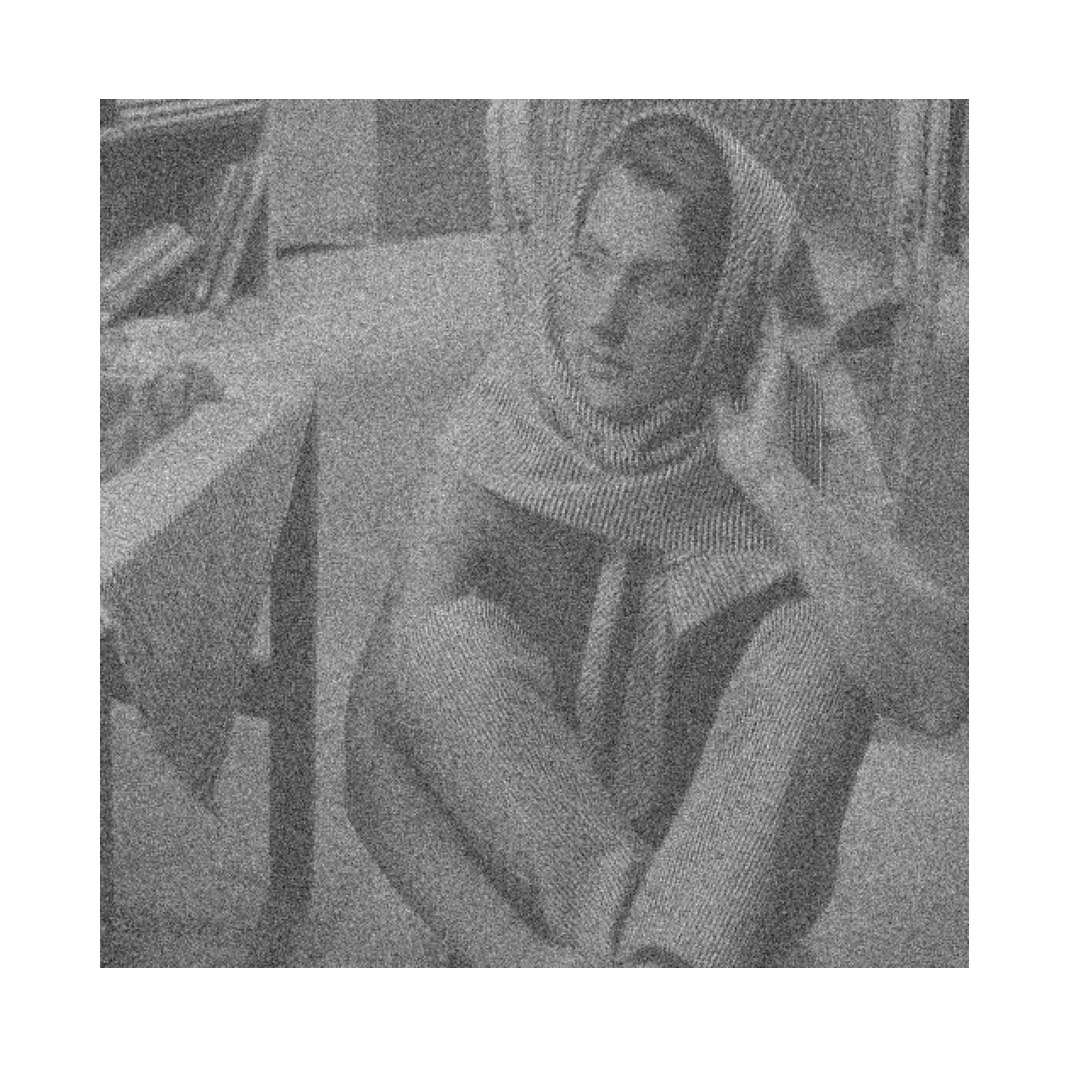

Val snr 16.583166213597625


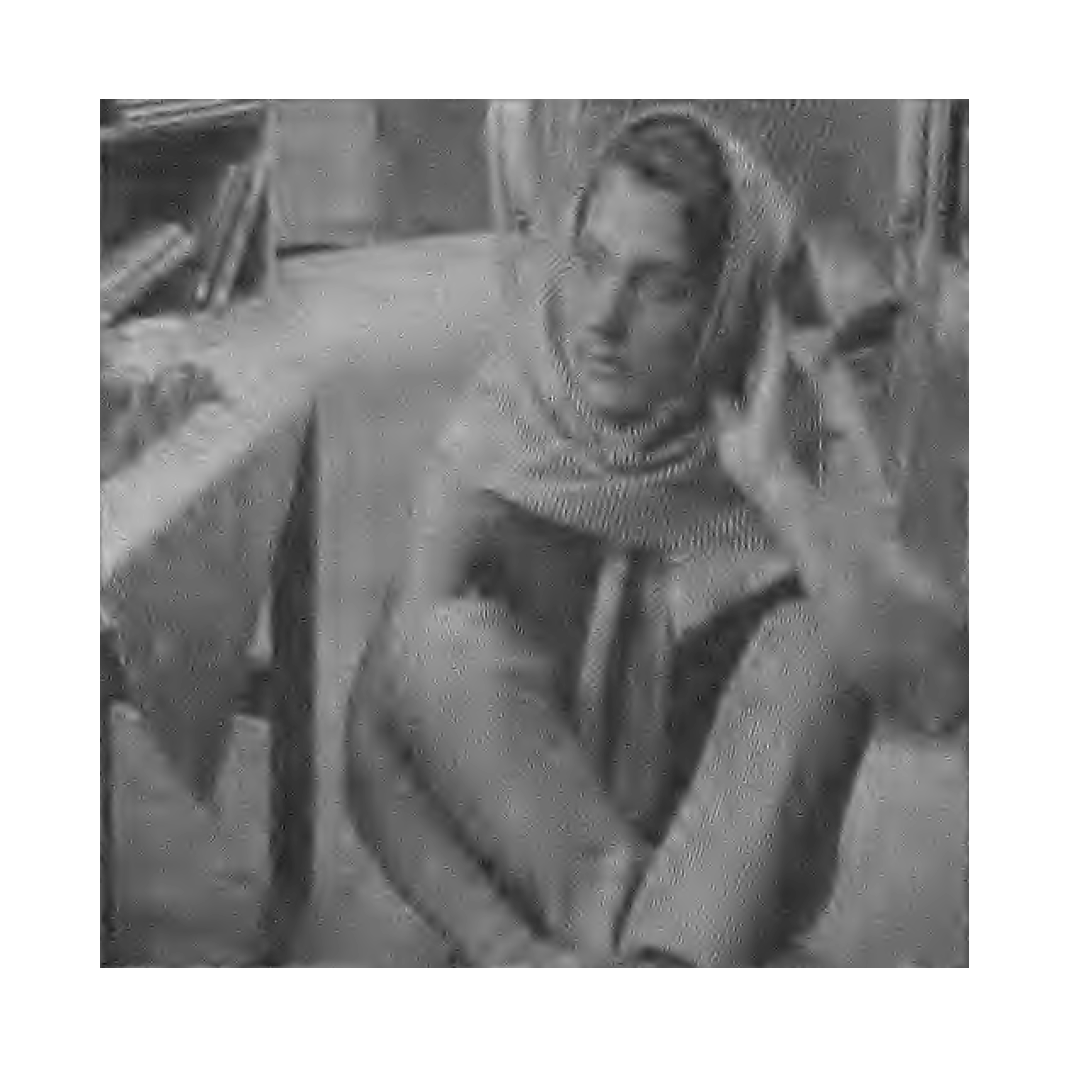

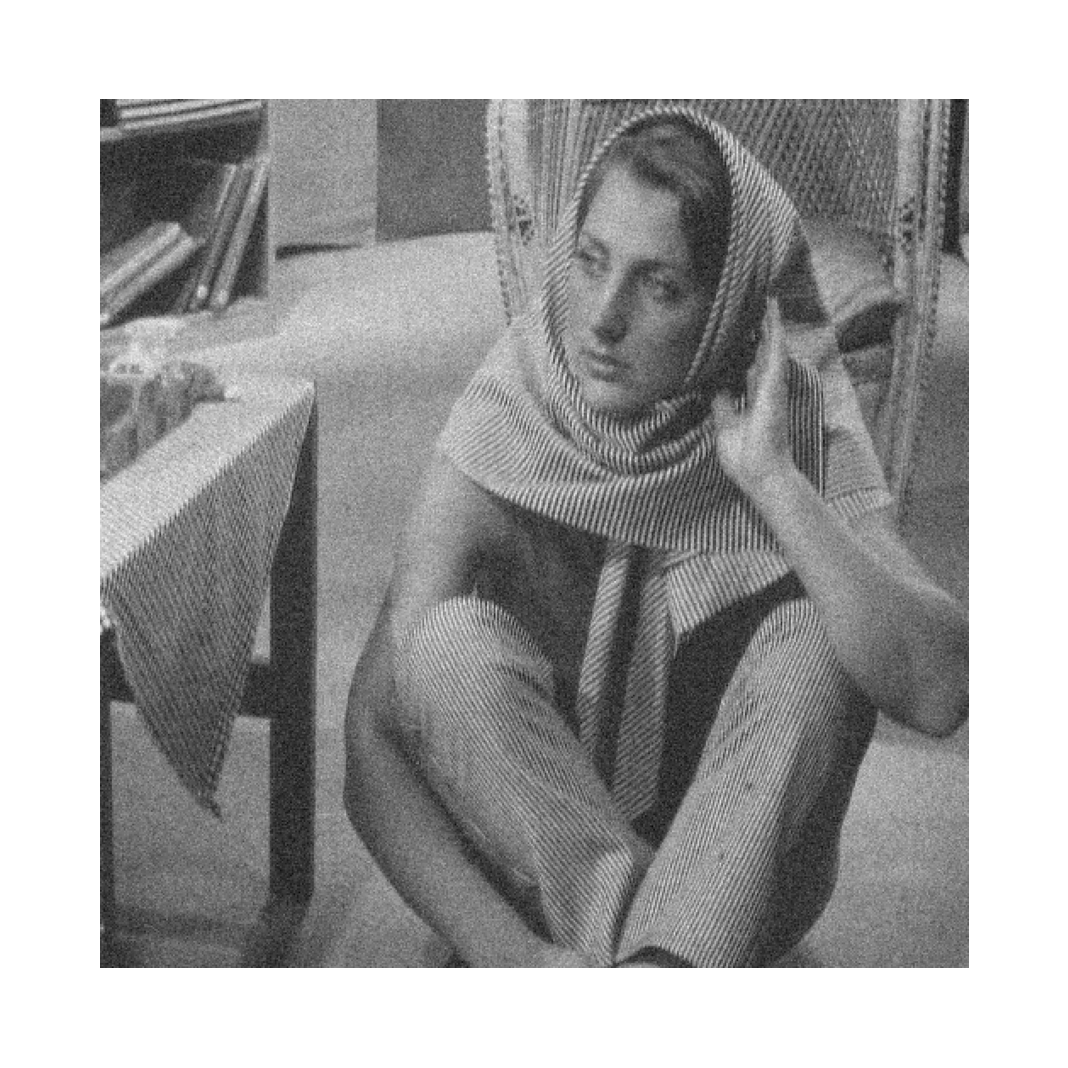

Val snr 22.64201414543116


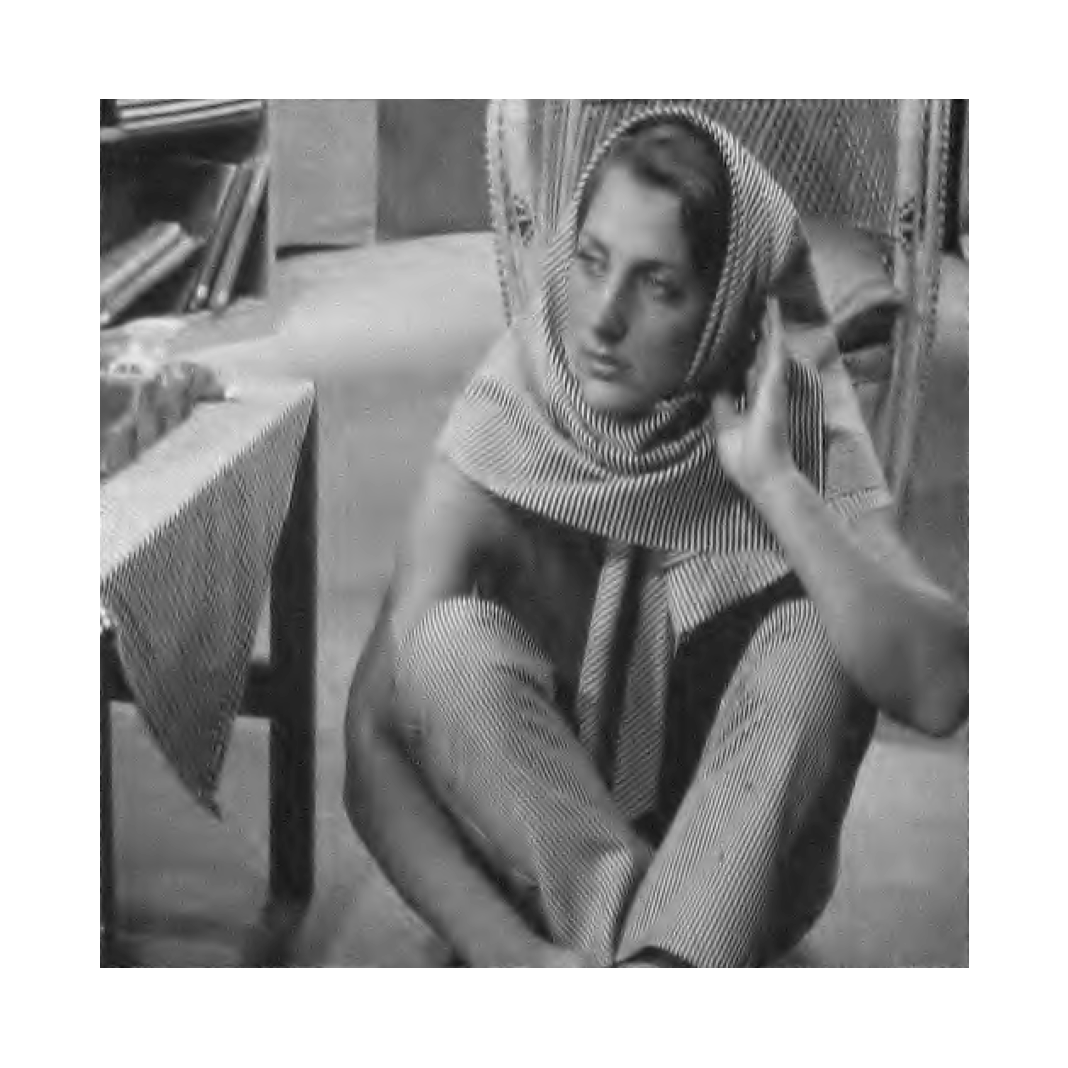

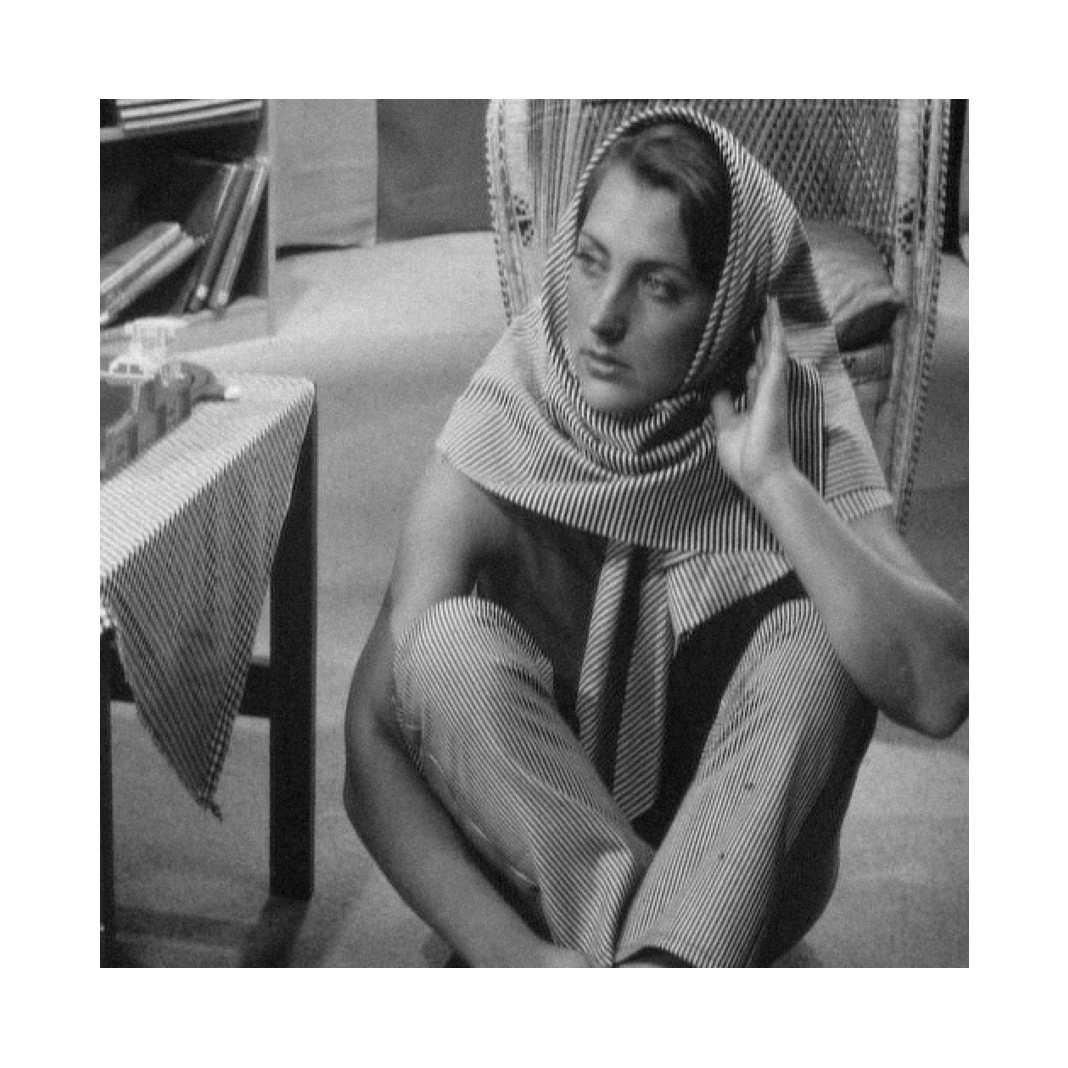

Val snr 30.206302024037385


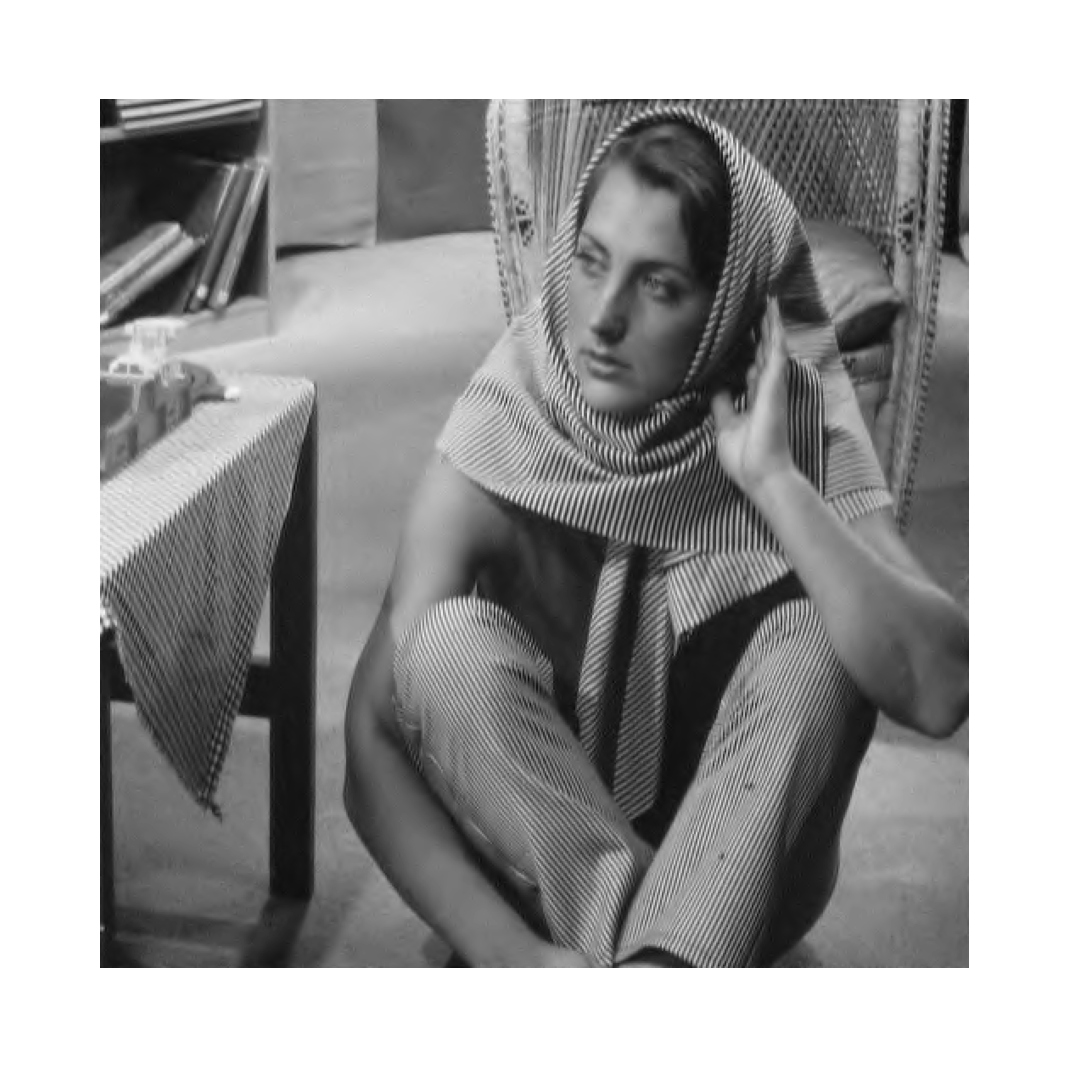

In [26]:
N = barb.shape[0] * barb.shape[1]
    
m = 4
Jmin = 2
h = compute_wavelet_filter("Daubechies", 6)

[dY,dX] = np.meshgrid(arange(0, m), arange(0, m))
delta = np.concatenate((dX.reshape(m*m, 1), dY.reshape(m*m, 1)), axis=1)

for sigma in sigma_vals:
    noise = gaussian_noise(barb, 0, sigma)
    noisy = barb + noise
    
    show_image("Noisy image with sigma = " + str(sigma), noisy)
    
    
    
    fTI = np.zeros([barb.shape[0], barb.shape[1]])
    T = 3*sigma
    
    for i in arange(0, m*m):
        fS = circshift(noisy, delta[i,:])
        a = perform_wavortho_transf(fS, Jmin, 1, h)
        aT = thresh_hard(a,T)
        fS = perform_wavortho_transf(aT, Jmin, -1, h)
        fS = circshift(fS, -delta[i,:])
        fTI = i / (i+1.0) * fTI + 1.0/(i+1) * fS

    val_snr = snr(barb, fTI)
    print("Val snr", val_snr)
    show_image("Denoised image with sigma = " + str(val_snr), fTI)